In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import erf
from numpy.lib.scimath import sqrt
from pykalman import KalmanFilter
from scipy.optimize import fmin
from scipy.stats import kstest
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

In [2]:
# Importing Data

data = pd.read_csv("data.csv").set_index(["date", "ticker"])
close_df = data["last"].unstack()
volume_df = data["volume"].unstack()


In [3]:
# Only Trade Stocks with high turnover (daily turnover > 100m)

turnover_threshold = 100e6
stocks_to_trade = []

for stock in close_df.columns:
    turnover = close_df.iloc[0][stock] * volume_df.iloc[0][stock]
    if turnover > turnover_threshold:
        stocks_to_trade.append(stock)
        
close_df = close_df[stocks_to_trade]
volume_df = volume_df[stocks_to_trade]
        
print("There are %d stocks after filtering." % len(stocks_to_trade))

There are 224 stocks after filtering.


In [4]:
# Correlation Matrix

close_df.corr()

ticker,1332 JT,1334 JT,1605 JT,1721 JT,1801 JT,1802 JT,1803 JT,1812 JT,1925 JT,1928 JT,...,9503 JT,9531 JT,9532 JT,9602 JT,9613 JT,9681 JT,9735 JT,9766 JT,9983 JT,9984 JT
ticker,,,,,,,,,,,,,,,,,,,,,
1332 JT,1.000000,0.371189,-0.153716,0.741131,0.858617,0.882700,0.821200,0.841346,0.869660,0.732043,...,0.620162,0.238989,0.497155,0.820248,0.822723,-0.112339,0.822459,0.776800,0.415677,0.406807
1334 JT,0.371189,1.000000,-0.409423,0.176999,0.389852,0.479424,0.333096,0.480879,0.632853,0.699941,...,0.794537,0.881677,0.829323,0.720208,0.489178,0.797515,0.610411,0.456751,0.633617,0.388324
1605 JT,-0.153716,-0.409423,1.000000,-0.247122,0.013071,-0.149591,-0.011473,-0.046277,-0.105472,-0.359470,...,0.185918,0.436057,0.064738,-0.335644,-0.277137,-0.066050,-0.388056,-0.245049,-0.343943,-0.352280
1721 JT,0.741131,0.176999,-0.247122,1.000000,0.753712,0.751436,0.645194,0.732447,0.790091,0.832139,...,0.489603,0.168698,0.491624,0.888785,0.870362,-0.074744,0.877871,0.826301,0.757283,0.768154
1801 JT,0.858617,0.389852,0.013071,0.753712,1.000000,0.927530,0.903056,0.959691,0.936833,0.718553,...,0.688196,0.343209,0.645834,0.750070,0.778037,-0.093527,0.745334,0.825887,0.367614,0.425260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681 JT,-0.112339,0.797515,-0.066050,-0.074744,-0.093527,-0.084371,-0.151399,-0.061424,-0.036646,0.029510,...,0.240955,0.060345,0.121739,-0.004683,-0.058886,1.000000,-0.047966,-0.011976,0.113266,0.163501
9735 JT,0.822459,0.610411,-0.388056,0.877871,0.745334,0.812257,0.763227,0.729323,0.815991,0.917890,...,0.481180,0.265611,0.640858,0.931939,0.939264,-0.047966,1.000000,0.754583,0.759712,0.688703
9766 JT,0.776800,0.456751,-0.245049,0.826301,0.825887,0.821395,0.700967,0.873502,0.880242,0.749006,...,0.513348,0.047411,0.422789,0.813358,0.813993,-0.011976,0.754583,1.000000,0.566534,0.680603


In [5]:
'''
Function getCorrelatedPairs()

Objective:
    -Return an array of pairs (in tuples) with the correlation over corr_threshold. When short_window is input,
     both short term correlation and long term correlation are computed. Pairs showing both long term correlation
     short term correlation are returned

Parameters:
    close_df: Pandas DataFrame with closing prices
    short_window: Get short term correlation by recursively calling the function with a shorter dataFrame. 
                  Default is None
    corr_threshold: Minimum threshold on correlation. Default is 0.95

Output:
    Array of pairs (in tuples) with correlation over corr_threshold
'''

def getCorrelatedPairs(close_df, min_periods=14, short_window=None, corr_threshold=0.95):
    
    if short_window:
        short_term_correlated_list = getCorrelatedPairs(close_df[-short_window:], None, corr_threshold)
        return [pair for pair in getCorrelatedPairs(close_df, None, corr_threshold) \
                    if pair in short_term_correlated_list]
        
    corr_df = close_df.corr()
    highCorr = corr_df[((corr_df >= corr_threshold) & (corr_df < 1))]
    highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates().dropna()
    return highCorr.index.to_flat_index().to_list()

In [6]:
'''
Function backtestPair()

Objective:
    -Deploy Kalman Filter to predict closing price of a stock with its pair
    -Test the cointegration of input pair within a specific time by:
         1. Checking spread stationarity with Augmented Dickey Fuller Test
         2. Checking spread normality with Kolmogorov–Smirnov test
    -If the pair is cointegrated, compute the spread

Parameters:
    pair: A tuple with length 2. Each element in the tuple refers to a ticker
    close_df_training: Pandas DataFrame with closing prices. The dataframe is used to train the Kalman Filter and
                       test for stationarity
    close_df_trading: Pandas DataFrame with close prices. The dataframe is used for trading if stationarity 
                       condition is passed
    adf_threshold: Threshold for adf test. Default is 0.05
    ks_threshold: Threshold for kstest. Default is 0.05
    
Output:
    -If the pair is not cointegrated, return None
    -Otherwise, return a DataFrame with index Date and columns [stockA, stockB, standard_spread]
'''

def backtestPair(pair, close_df_training, close_df_trading, adf_threshold=0.05, ks_threshold=0.05, show_plot=False):
    
    stockA = pair[0]
    stockB = pair[1]
    
    training_df = close_df_training[[stockA, stockB]].dropna(axis=0)
    trading_df = close_df_trading[[stockA, stockB]].dropna(axis=0)
    
    n = len(training_df) + len(trading_df)
    n_dim_state = 2

    history_state_means = np.zeros((n, n_dim_state))
    history_state_covs = np.zeros((n, n_dim_state, n_dim_state))
    
    # Part 1: Deploying Kalman Filter
    
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)

    obs_mat = [training_df.iloc[0,1], 1]
    
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=np.zeros(2),
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=1.0,
                      transition_covariance=trans_cov)
    
    history_state_means[0], history_state_covs[0] = kf.filter(np.asarray(training_df.iloc[0,0]))

    
    for idx, row in enumerate(training_df.itertuples(index=False)): # Update the Kalman Filter

        if idx == 0:
            continue

        obs_mat = np.asarray([[training_df.iloc[idx,1], 1]])

        history_state_means[idx], history_state_covs[idx] = \
            kf.filter_update(history_state_means[idx-1],
                             history_state_covs[idx-1],
                             observation = training_df.iloc[idx,0],
                             observation_matrix=obs_mat)
                    
    training_df["slope"] = history_state_means[:,0][:len(training_df)]
    training_df["intercept"] = history_state_means[:,1][:len(training_df)]
    training_df["spread"] = training_df.iloc[:,0] - \
        (training_df["intercept"] + training_df["slope"]*training_df.iloc[:,1])
    
    adf_pvalue = adfuller(training_df["spread"])[1]
    kstest_pvalue = kstest(training_df["spread"], "norm")[1]
    
    if adf_pvalue >= adf_threshold or kstest_pvalue >= ks_threshold:
        return None
        
    for idx, row in enumerate(trading_df.itertuples(index=False)): 
        
        history_state_idx = idx + len(training_df)
            
        obs_mat = np.asarray([[trading_df.iloc[idx,1], 1]])

        history_state_means[history_state_idx], history_state_covs[history_state_idx] = \
            kf.filter_update(history_state_means[history_state_idx-1],
                             history_state_covs[history_state_idx-1],
                             observation = trading_df.iloc[idx,0],
                             observation_matrix=obs_mat)
        
    trading_df["slope"] = history_state_means[:,0][len(training_df):]
    trading_df["intercept"] = history_state_means[:,1][len(training_df):]
    trading_df["spread"] = trading_df.iloc[:,0] - \
        (trading_df["intercept"] + trading_df["slope"]*trading_df.iloc[:,1])
    trading_df["spread"] = trading_df["spread"]/np.std(training_df["spread"])
    
    return trading_df[[stockA, stockB, "spread"]]

In [7]:
'''
Function getOptimalTradingThreshold()

Objective:
    -Assume the spread follows normal distribution
    -We long or short the pair whenever the spread reaches s0 and rewind the position when it restores to zero. 
     Under the trading strategy above, the profit is s0 and the probability of trading in a day is 2*(1-F(s0)),
     where F(s0) is the CDF of standard normal.
    -The function intends to determine the optimal s0 to maximize profit

Parameters:
    N/A

Output:
    A tuple with optimal lower and upper threshold for trading
'''


def getOptimalTradingThreshold():
    
    def norm_cdf(z):
        return (1.0 + erf(z/sqrt(2.0))) / 2.0
    
    z = fmin(lambda z: -z*2*(1-norm_cdf(z)), 0, disp=False)[0]
    
    lower_threshold = -z
    upper_threshold = z
    
    return (lower_threshold, upper_threshold)

In [8]:
'''
Function getTradingSignal()

Objective:
    -Generate trading singal for the input pair.
    -The input spread should be stationary and follows a normal distribution with mean zero. If the spread deviates
     from a zero significantly, long/short the spread and rewind the position when it restores to zero.
     
Parameters:
    -trading_df: Pandas DataFrame generated from backtestPair()
    
Output:
    -Pandas DataFrame with columns "signal" appended
'''

def getTradingSignal(trading_df):
    
    trading_df_copy = trading_df.copy()
    signal = []
    
    lower_threshold, upper_threshold = getOptimalTradingThreshold()
    
    if trading_df_copy.iloc[0].spread > upper_threshold:
        signal.append(-1)
    elif trading_df_copy.iloc[0].spread < lower_threshold:
        signal.append(1)
    else:
        signal.append(0)
    
    for dateidx in range(1, len(trading_df_copy)):
        if trading_df_copy.iloc[dateidx].spread > upper_threshold:
            signal.append(-1) # Short StockA; Long StockB
        elif trading_df_copy.iloc[dateidx].spread < lower_threshold:
            signal.append(1) # Long StockA; Short StockB
        elif trading_df_copy.iloc[dateidx].spread < 0 and signal[-1] == -1:
            signal.append(0)
        elif trading_df_copy.iloc[dateidx].spread > 0 and signal[-1] == 1:
            signal.append(0)   
        else:
            signal.append(signal[-1])
            
    trading_df_copy["signal"] = signal
    
    return trading_df_copy

In [9]:
'''
Function getCumPnl()

Objective:
    -Compute P/L given in the dataframe given
    
Parameters:
    trading_df: Pandas Dataframe generated from getTradingSingal()
    show_plot: Show the trading signal plot and cumulative P/L plot. Default is False
    print_output: Print the cumulative P/L of a pair. Default is False
    
Ouptut:
    Pandas DataFrame with column ["pnl"]
'''

def getCumPnl(trading_df, show_plot=False, print_output=False):
    
    trading_df_copy = trading_df.copy()
    
    stockA = trading_df_copy.columns[0]
    stockB = trading_df_copy.columns[1]
    cum_pnl = [0.0]
    
    trading_df_copy["returnA"] = trading_df_copy[stockA].pct_change()
    trading_df_copy["returnB"] = trading_df_copy[stockB].pct_change()
    
    for dateidx in range(len(trading_df_copy)-1):
        
        signal = trading_df_copy.iloc[dateidx].signal
        dollarValue = 10000
        
        if signal < 0: 
            daily_pnl = dollarValue * \
                (trading_df_copy.iloc[dateidx+1].returnB - trading_df_copy.iloc[dateidx+1].returnA)
            cum_pnl.append(cum_pnl[-1] + daily_pnl)
        elif signal > 0:
            daily_pnl = dollarValue * \
                (trading_df_copy.iloc[dateidx+1].returnA - trading_df_copy.iloc[dateidx+1].returnB)
            cum_pnl.append(cum_pnl[-1] + daily_pnl)
        elif signal == 0:
            cum_pnl.append(cum_pnl[-1])
            continue
            
    trading_df_copy["Cumulative PnL"] = cum_pnl
            
    if show_plot:
        fig, axs = plt.subplots(2,1, figsize=(45,20))
        
        lower_threshold, upper_threshold = getOptimalTradingThreshold()
                                
        axs[0].plot(trading_df_copy.spread, color="black", label="spread")
        axs[0].axhline(lower_threshold, linestyle="--", color="blue")
        axs[0].axhline(upper_threshold, linestyle="--", color="blue")
        axs[0].plot(trading_df_copy.signal, color="red", label="signal")
        axs[0].legend()
                
        axs[1].plot(trading_df_copy.index, cum_pnl, color="black")
    
    if print_output:
        print("Cumulative P/L for pair %s-%s: %d" % (stockA, stockB, cum_pnl[-1]))
    
    return trading_df_copy["Cumulative PnL"]

In [10]:
'''
Function getPortfolioPnl()

Objective:
    -Aggregate PnL of all pairs to obtain Portfolio PnL over a specific period
    
Parameters:
    cum_pnl_df_arr: An array of Pandas DataFrame cum_pnl generated from getCumPnl()
    show_plot: Show the portfolio cumulative P/L plot. Default is False
    print_output: Print the cumulative P/L of a pair. Default is False

Output:
    Pandas DataFrame with column ["Total Portfolio PnL"]

'''

def getPortfolioPnl(df_index, cum_pnl_df_arr, show_plot=False, print_output=False):
    
    portfolio_pnl_df = pd.DataFrame(index=df_index)
    
    for idx, cum_pnl_df in enumerate(cum_pnl_df_arr):
        portfolio_pnl_df[idx] = portfolio_pnl_df.index.map(dict(cum_pnl_df).get)
        portfolio_pnl_df[idx].replace(to_replace=0.0, method='ffill')
        
    portfolio_pnl_df["Total Portfolio PnL"] = portfolio_pnl_df.sum(axis=1)
    
    if show_plot:
        portfolio_pnl_df["Total Portfolio PnL"].plot()
        
    if print_output:
        print("Total Portfolio PnL: %d" % portfolio_pnl_df["Total Portfolio PnL"][-1])
    
    return portfolio_pnl_df["Total Portfolio PnL"]



In [11]:
'''
Function getOverallPortfolioPnl()

Objective:
    -Merge Portfolio Pnl DataFrame generated from getPortfolioPnl() to get an overall portfolio PnL over 
     the entire investment duration. 

Parameters:
    portfolio_pnl_df_arr: An array of Pandas DataFrame portfolio_pnl_df generated from getPortfolioPnl()
    show_plot: Show the portfolio cumulative P/L plot. Default is False
    print_output: Print the cumulative P/L of a pair. Default is False
    
Output:
    Pandas DataFrame with column ["Total Portfolio PnL"]
'''

def getOverallPortfolioPnl(portfolio_pnl_df_arr, show_plot=False, print_output=False):
    
    temp = portfolio_pnl_df_arr
    
    for idx in range(len(temp)):
        
        if idx == 0:
            continue
        
        temp[idx] += temp[idx-1][-1]
        
    overallPortfolioPnl = pd.concat(temp, axis=0)
    
    if show_plot:
        fig, axs = plt.subplots(1,1, figsize=(45,20))                                        
        axs.plot(overallPortfolioPnl, color="red", label="signal")

        
    if print_output:
        print("The total P/L over the entire period is: %d" % overallPortfolioPnl[-1])

    return overallPortfolioPnl

In [12]:
training_window = 30
trading_window = 14
max_pair_to_trade = 50

portfolio_pnl_df_arr = []

for dateidx in range(training_window, len(close_df), trading_window):
        
    cum_pnl_df_arr = []
    
    training_df = close_df[dateidx-training_window:dateidx]
    trading_df = close_df[dateidx:dateidx+trading_window]
    
    pairs = getCorrelatedPairs(training_df, trading_window, corr_threshold=0.95)[:max_pair_to_trade]

    for pair in pairs:
        try:
            pairs_df = backtestPair(pair, training_df, trading_df, adf_threshold=0.95, ks_threshold=0.95)
        except:
            continue
        if pairs_df is not None and len(pairs_df):
            cum_pnl_df_arr.append(getCumPnl(getTradingSignal(pairs_df)))
            
    portfolio_pnl_df_arr.append(getPortfolioPnl(trading_df.index, cum_pnl_df_arr))


In [13]:
overallPortfolioPnl = getOverallPortfolioPnl(portfolio_pnl_df_arr, print_output=True)

The total P/L over the entire period is: 250023


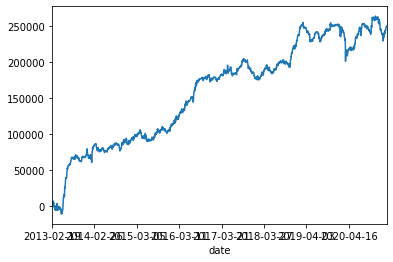

In [15]:
overallPortfolioPnl.plot()